<a href="https://github.com/arleypinho/datasets/blob/main/modeloclassifica%C3%A7%C3%A3o_predicao_alunos_oficial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelo de Machine Learning MVP - Arley Silva de Pinho

# Objetivo:
# Este modelo de machine learning visa prever se um aluno será Aprovado ou Reprovado
# com base em características e comportamentos acadêmicos.

# Variáveis de Entrada:
# O modelo utiliza as seguintes variáveis: idade, gênero, etnia, nível de educação dos pais,
# horas de estudo semanais, número de faltas, participação em aulas de reforço, apoio dos pais,
# atividades extracurriculares, esportes, música e voluntariado.

# Funcionamento:
# Baseado em um classificador Support Vector Machine (SVM), o modelo foi treinado em um conjunto
# de dados rotulado e otimizado com escalonamento de dados e ajuste de hiperparâmetros.

# Interpretação:
# Um valor de 1 indica uma previsão de possível Aprovação, enquanto um valor de 0 indica uma possível Reprovação.

# Uso:
# Este modelo pode ser aplicado em contextos educacionais para identificar áreas de risco no desempenho
# acadêmico, permitindo intervenções direcionadas para estudantes em risco de baixo desempenho.


In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Carga do Dataset

# Nesta seção, informamos a URL direta para download do dataset que será utilizado para treinar o modelo. O dataset contém informações sobre o desempenho dos alunos e suas características, que serão fundamentais para as previsões.
# Utilizamos a biblioteca **pandas** para ler o arquivo CSV diretamente da URL. Após a leitura, exibimos as primeiras linhas do dataset para termos uma visão inicial dos dados disponíveis. Isso nos ajudará a entender as variáveis e suas respectivas distribuições antes de prosseguir com a análise e o pré-processamento.


In [2]:
# Informa a URL direta para download do dataset
url = "https://raw.githubusercontent.com/arleypinho/datasets/main/Student_performance_data%20_.csv"

# Lê o arquivo
dataset = pd.read_csv(url)

# Mostra as primeiras linhas do dataset
dataset.head()


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


## Separação em conjunto de treino e conjunto de teste com holdout

# Nesta seção, definimos o tamanho do conjunto de teste e a semente aleatória para garantir a reprodutibilidade dos resultados. O conjunto de teste será 20% do total, enquanto os 80% restantes serão utilizados para o treinamento do modelo.

# Também simplificamos a variável-alvo **GradeClass**, transformando-a em uma variável binária. As classes 0, 1 e 2 serão mapeadas para 1 (indicando sucesso), enquanto as demais serão mapeadas para 0 (indicando insucesso). Isso facilita a interpretação dos resultados do modelo.

# A seguir, separamos os dados em variáveis independentes (X) e a variável dependente (y). As variáveis independentes incluem todas as colunas, exceto 'StudentID', 'GradeClass' e 'GPA', que não são necessárias para a previsão.

# Utilizamos a função `train_test_split` para dividir os dados em conjuntos de treinamento e teste, garantindo que a distribuição da variável-alvo seja preservada através do parâmetro `stratify`. Isso é importante para que o modelo tenha uma representação equilibrada de ambas as classes no conjunto de teste.

# Por fim, configuramos os parâmetros para a validação cruzada. Optamos por uma validação cruzada estratificada com 10 partições, permitindo uma avaliação mais robusta da performance do modelo. A semente aleatória é utilizada novamente para garantir que os resultados sejam reprodutíveis.


In [3]:
# Definir o tamanho do conjunto de teste e a semente aleatória
test_size = 0.20 # tamanho do conjunto de teste (20%)
seed = 7 # semente aleatória para reprodutibilidade

# Simplificando a variável-alvo
dataset['GradeClass'] = dataset['GradeClass'].apply(lambda x: 1 if x in [0, 1, 2] else 0)
# Separação em conjuntos de treino e teste
X = dataset.drop(columns=['StudentID', 'GradeClass', 'GPA'])
y = dataset['GradeClass']

# Divisão dos dados em treino e teste (com estratificação)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    shuffle=True,
                                                    random_state=seed,
                                                    stratify=y)

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)


## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

# Nesta seção, definimos uma semente global para garantir a reprodutibilidade dos resultados em todas as operações aleatórias. Em seguida, criamos uma lista para armazenar os modelos de machine learning que serão avaliados.

# Os modelos escolhidos para esta análise incluem:
# - **KNN (K-Nearest Neighbors)**: Um algoritmo simples e eficaz que classifica uma amostra com base na maioria das classes de seus vizinhos mais próximos.
# - **CART (Classification and Regression Trees)**: Um classificador que utiliza árvores de decisão para dividir os dados em subconjuntos homogeneizados.
# - **NB (Naive Bayes)**: Um modelo probabilístico baseado no teorema de Bayes, que assume que as características são independentes entre si.
# - **SVM (Support Vector Machine)**: Um classificador que busca o hiperplano que maximiza a margem entre as classes.

# Para cada modelo, utilizamos a validação cruzada estratificada com 10 partições para avaliar sua performance. O resultado da acurácia média e o desvio padrão são calculados e exibidos para cada modelo.

# Por fim, geramos um boxplot para visualizar a comparação das acurácias dos diferentes modelos. Esse gráfico nos permite identificar rapidamente qual modelo apresenta melhor desempenho em termos de acurácia, além de visualizar a variabilidade dos resultados.


KNN: 0.866705 (0.027127)
CART: 0.802424 (0.023306)
NB: 0.877160 (0.017620)
SVM: 0.880309 (0.025754)


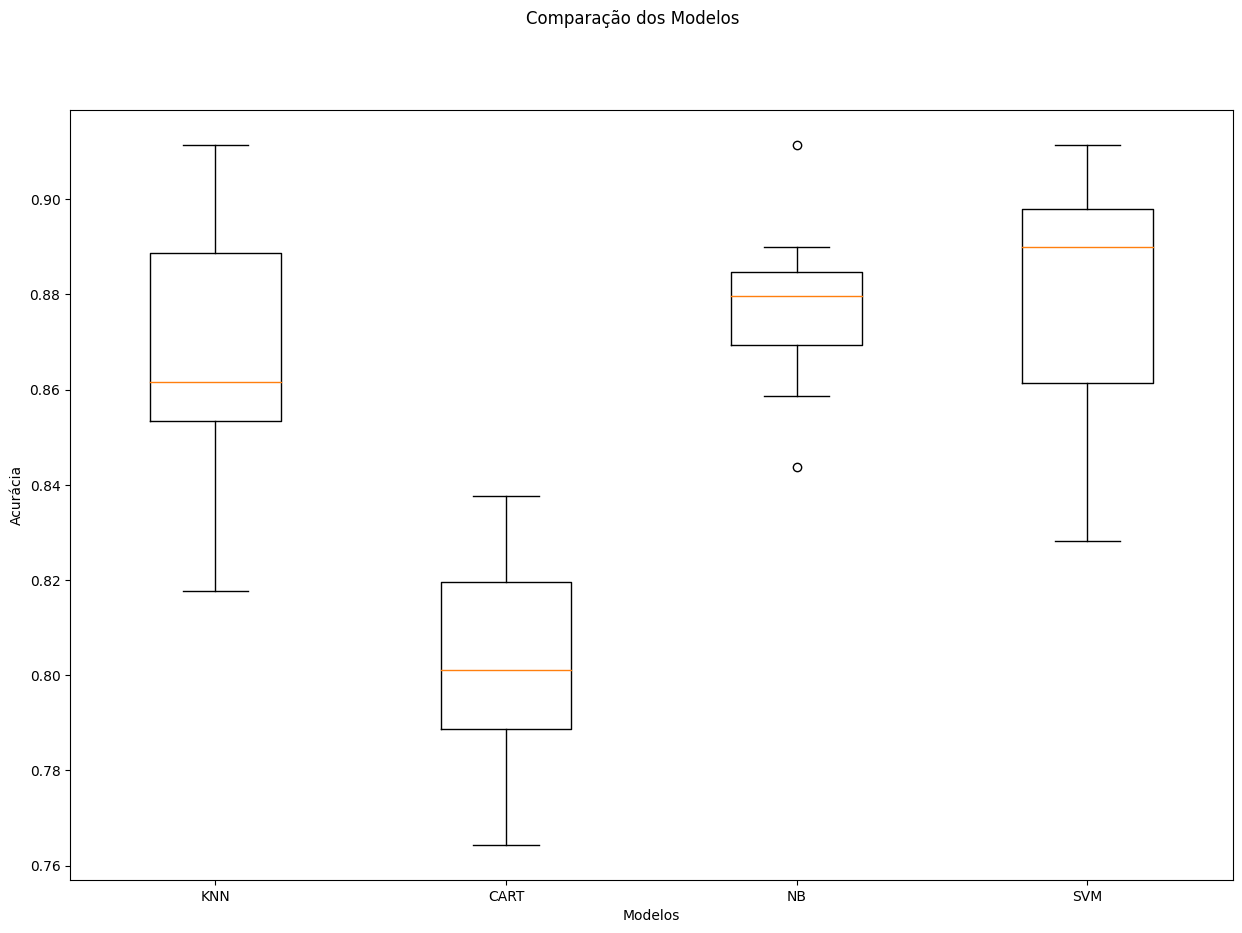

In [4]:
# Definir uma semente global
np.random.seed(7)

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    # Avaliação usando validação cruzada
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    # Exibição dos resultados
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xlabel('Modelos')
plt.ylabel('Acurácia')
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

# Nesta seção, definimos uma semente global para garantir a reprodutibilidade dos resultados. Em seguida, criamos listas para armazenar os pipelines e os resultados obtidos durante a avaliação dos modelos.

# Utilizamos quatro algoritmos de machine learning: KNN, CART, Naive Bayes e SVM, cada um testado em três configurações diferentes de pré-processamento de dados:
# 1. **Dataset Original**: Os dados são utilizados sem qualquer transformação.
# 2. **Dataset Padronizado**: Os dados são padronizados utilizando `StandardScaler`, que remove a média e escala os dados para a unidade de variância.
# 3. **Dataset Normalizado**: Os dados são normalizados utilizando `MinMaxScaler`, que escala os dados para um intervalo específico, geralmente entre 0 e 1.

# Cada pipeline é criado utilizando a classe `Pipeline`, que permite encadear transformações e a estimativa final. Para cada modelo, realizamos a validação cruzada utilizando a técnica de `StratifiedKFold` para garantir que a distribuição das classes seja mantida em cada partição.

# Os resultados da validação cruzada são calculados e apresentados, mostrando a acurácia média e o desvio padrão para cada modelo. Para facilitar a comparação, geramos um boxplot que ilustra as performances dos modelos em cada uma das configurações de pré-processamento.


KNN-orig: 0.867 (0.027)
CART-orig: 0.802 (0.023)
NB-orig: 0.877 (0.018)
SVM-orig: 0.880 (0.026)
KNN-padr: 0.809 (0.027)
CART-padr: 0.805 (0.023)
NB-padr: 0.877 (0.018)
SVM-padr: 0.880 (0.021)
KNN-norm: 0.783 (0.022)
CART-norm: 0.803 (0.027)
NB-norm: 0.877 (0.018)
SVM-norm: 0.878 (0.024)


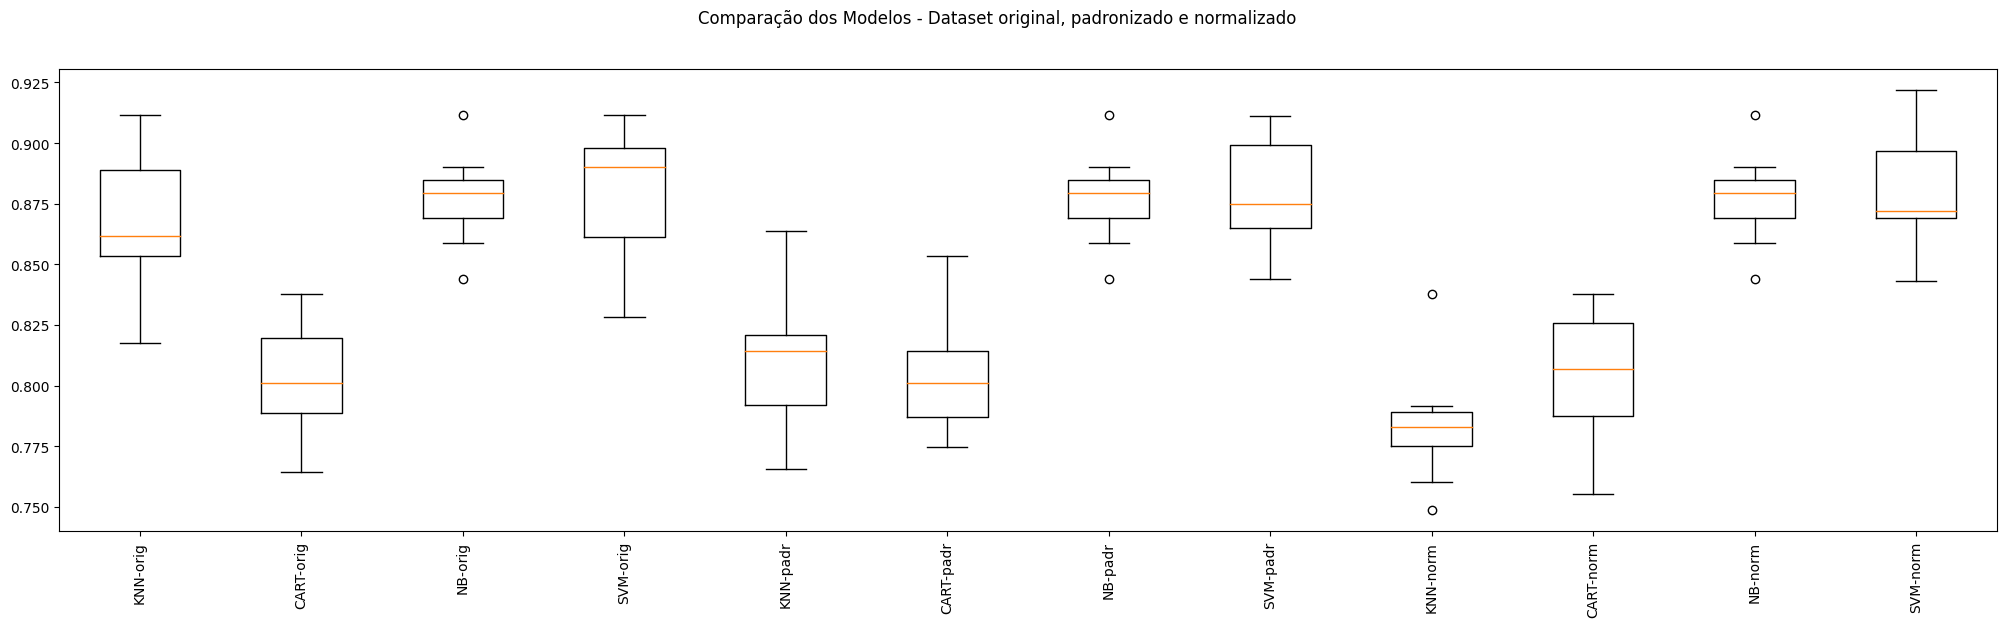

In [5]:
np.random.seed(7)  # Definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = KNeighborsClassifier()
cart = DecisionTreeClassifier()
naive_bayes = GaussianNB()
svm = SVC()

# Transformações que serão utilizadas
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([('classifier', knn)])))
pipelines.append(('CART-orig', Pipeline([('classifier', cart)])))
pipelines.append(('NB-orig', Pipeline([('classifier', naive_bayes)])))
pipelines.append(('SVM-orig', Pipeline([('classifier', svm)])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([('scaler', standard_scaler), ('classifier', knn)])))
pipelines.append(('CART-padr', Pipeline([('scaler', standard_scaler), ('classifier', cart)])))
pipelines.append(('NB-padr', Pipeline([('scaler', standard_scaler), ('classifier', naive_bayes)])))
pipelines.append(('SVM-padr', Pipeline([('scaler', standard_scaler), ('classifier', svm)])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([('scaler', min_max_scaler), ('classifier', knn)])))
pipelines.append(('CART-norm', Pipeline([('scaler', min_max_scaler), ('classifier', cart)])))
pipelines.append(('NB-norm', Pipeline([('scaler', min_max_scaler), ('classifier', naive_bayes)])))
pipelines.append(('SVM-norm', Pipeline([('scaler', min_max_scaler), ('classifier', svm)])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())  # Formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()


### Otimização dos hiperparâmetros

# Nesta seção, realizamos a busca de hiperparâmetros para o modelo SVM utilizando `GridSearchCV`. Primeiramente, definimos uma semente global para garantir a reprodutibilidade dos resultados.
# Três pipelines foram criados com diferentes configurações para o classificador SVM:
# 1. **SVM - Dataset Original**: O classificador SVM é aplicado sem qualquer transformação nos dados.
# 2. **SVM - Dataset Padronizado**: O classificador SVM é aplicado aos dados que foram padronizados utilizando `StandardScaler`.
# 3. **SVM - Dataset Normalizado**: O classificador SVM é aplicado aos dados que foram normalizados utilizando `MinMaxScaler`.
# Para cada pipeline, definimos um dicionário `param_grid` contendo os hiperparâmetros a serem otimizados:
# - `C`: Parâmetro de regularização que controla o trade-off entre maximizar a margem e minimizar o erro de classificação.
# - `gamma`: Parâmetro que define a influência de um único exemplo de treinamento, com opções para 'scale' e 'auto'.
# - `kernel`: Tipo de função do kernel a ser utilizada, sendo a única opção neste caso 'rbf' (Radial Basis Function).
# O `GridSearchCV` é utilizado para executar uma busca exaustiva sobre os hiperparâmetros especificados, utilizando validação cruzada (`StratifiedKFold`) para avaliar o desempenho. Para cada pipeline, a melhor configuração de hiperparâmetros encontrada e a respectiva acurácia são impressas.

## Observação sobre a Otimização dos Hiperparâmetros
# Durante o processo de otimização dos hiperparâmetros, percebi que a execução estava levando um tempo excessivo. Para contornar esse problema e acelerar o processo, optei por reduzir o número de hiperparâmetros no dicionário `param_grid`. Essa estratégia permitiu obter resultados mais rapidamente, facilitando a análise do desempenho do modelo SVM com diferentes configurações. No entanto, vale ressaltar que uma busca mais abrangente poderia ser realizada em futuras iterações para potencialmente encontrar configurações que resultem em uma maior acurácia.


In [6]:
np.random.seed(7)  # Definindo uma semente global para este bloco

# Lista de pipelines
pipelines = []

# Definindo o classificador e os scalers
svm = SVC(random_state=seed)
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

# Criando os pipelines
pipelines.append(('SVM-orig', Pipeline(steps=[('classifier', svm)])))
pipelines.append(('SVM-padr', Pipeline(steps=[('scaler', standard_scaler), ('classifier', svm)])))
pipelines.append(('SVM-norm', Pipeline(steps=[('scaler', min_max_scaler), ('classifier', svm)])))

# Definindo os parâmetros para a busca em grade
param_grid = {
    'classifier__C': [1, 10],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['rbf']
}

# Preparando e executando o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # Imprime a melhor configuração
    print("Pipeline: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))


Pipeline: SVM-orig - Melhor: 0.892329 usando {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Pipeline: SVM-padr - Melhor: 0.879780 usando {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Pipeline: SVM-norm - Melhor: 0.893376 usando {'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}


## Finalização do Modelo

# Nesta seção, utilizamos o melhor modelo encontrado durante a execução do `GridSearchCV`, que neste caso foi um classificador SVM com as seguintes configurações:

# - **C**: 1, que controla a penalidade do erro de classificação. Um valor menor faz com que o modelo seja mais simples e menos propenso a overfitting.
# - **gamma**: 'auto', que determina a forma do núcleo e a influência dos exemplos de treinamento.
# - **kernel**: 'rbf', que é o núcleo radial básico, adequado para problemas de classificação não linear.

# Após configurar o modelo, o treinamento é realizado com os dados de treinamento (`X_train` e `y_train`). Em seguida, o modelo é avaliado utilizando o conjunto de teste (`X_test`), onde calculamos a acurácia das previsões feitas pelo modelo. A acurácia é uma métrica importante que indica a proporção de previsões corretas em relação ao total de previsões realizadas.


In [7]:
# Preparação do modelo
# Usando o melhor modelo encontrado no GridSearchCV
model = SVC(
    C=1,
    gamma='auto',
    kernel='rbf',
    random_state=seed
)

# Treinamento do modelo com os dados de treino
model.fit(X_train, y_train)

# Estimativa da acurácia no conjunto de teste
predictions = model.predict(X_test)  # Predição usando o modelo treinado
accuracy = accuracy_score(y_test, predictions)  # Cálculo da acurácia

print("Acurácia no conjunto de teste:", accuracy)

Acurácia no conjunto de teste: 0.9018789144050104


#Preparação do Modelo com Todo o Dataset

# Após avaliarmos o desempenho do modelo utilizando o conjunto de teste, decidimos treinar o modelo final com todos os dados disponíveis. Isso é importante, pois ao utilizar o conjunto completo, o modelo pode capturar mais informações e padrões, potencialmente melhorando sua capacidade de generalização.

# Utilizaremos novamente o classificador SVM, com os mesmos hiperparâmetros identificados como os melhores durante a otimização. O modelo será treinado usando o conjunto completo de características (`X`) e as respectivas classes (`y`).

# Após o treinamento, o modelo treinado é exibido para que possamos verificar suas configurações e confirmar que ele foi corretamente preparado.


In [8]:
# Preparação do modelo com TODO o dataset
# Usando o melhor modelo encontrado no GridSearchCV
model = SVC(
    C=1,
    gamma='auto',
    kernel='rbf',
    random_state=seed
)
model.fit(X, y)  # Treinamento do modelo com os dados originais

# O modelo treinado é:
print(model)


SVC(C=1, gamma='auto', random_state=7)


## Simulando a aplicação do modelo em dados não vistos

# Nesta seção, realizaremos simulações com novos conjuntos de dados para prever a probabilidade de desistência dos alunos com base em suas características. Criamos três exemplos de dados novos que representam diferentes perfis de alunos, variando em idade, gênero, etnia, educação parental, tempo de estudo semanal, faltas, entre outros fatores.

# Esses novos dados serão utilizados para fazer previsões usando o modelo SVM que foi treinado anteriormente. As previsões ajudarão a entender como o modelo se comporta com dados que não foram vistos durante o treinamento.

# Após realizar as previsões, os resultados serão exibidos, indicando a probabilidade de cada aluno ser Aprovado ou Reprovado.


In [9]:
# Simulações com diferentes conjuntos de dados

# Exemplo de dados novos 1
new_data_1 = pd.DataFrame({
    'Age': [20],
    'Gender': [1],
    'Ethnicity': [1],
    'ParentalEducation': [2],
    'StudyTimeWeekly': [10],
    'Absences': [5],
    'Tutoring': [0],
    'ParentalSupport': [1],
    'Extracurricular': [1],
    'Sports': [0],
    'Music': [1],
    'Volunteering': [0],
})

# Exemplo de dados novos 2
new_data_2 = pd.DataFrame({
    'Age': [22],
    'Gender': [0],
    'Ethnicity': [3],
    'ParentalEducation': [4],
    'StudyTimeWeekly': [20],
    'Absences': [2],
    'Tutoring': [1],
    'ParentalSupport': [2],
    'Extracurricular': [1],
    'Sports': [1],
    'Music': [0],
    'Volunteering': [1],
})

# Exemplo de dados novos 3
new_data_3 = pd.DataFrame({
    'Age': [19],
    'Gender': [1],
    'Ethnicity': [0],
    'ParentalEducation': [1],
    'StudyTimeWeekly': [5],
    'Absences': [10],
    'Tutoring': [0],
    'ParentalSupport': [0],
    'Extracurricular': [0],
    'Sports': [0],
    'Music': [0],
    'Volunteering': [0],
})

# Fazer previsões
predictions_1 = model.predict(new_data_1)
predictions_2 = model.predict(new_data_2)
predictions_3 = model.predict(new_data_3)

# Exibir os resultados
print("Previsão para new_data_1:", predictions_1[0])
print("Previsão para new_data_2:", predictions_2[0])
print("Previsão para new_data_3:", predictions_3[0])


Previsão para new_data_1: 1
Previsão para new_data_2: 0
Previsão para new_data_3: 0


## Salva o modelo treinado em um arquivo

In [10]:
# Salvar o modelo treinado em um arquivo
model_filename = 'modelo_svm_aprovacao_reprovacao.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Modelo salvo como {model_filename}")

# Carregar o modelo salvo
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Fazer previsões com o modelo carregado
predictions_loaded_model = loaded_model.predict(X_test)


Modelo salvo como modelo_svm_aprovacao_reprovacao.pkl


# Resumo dos Principais Achados
Neste trabalho, desenvolvemos um modelo de classificação para prever a probabilidade de Aprovação ou Reprovação dos alunos
com base em diversas características, como idade, gênero, etnia, educação parental, tempo de estudo semanal e outros fatores relevantes.

Os resultados da validação cruzada indicaram que o modelo SVM com kernel radial (RBF) obteve a melhor acurácia,
destacando-se entre os outros algoritmos testados, como KNN, Decision Tree e Naive Bayes.
Essa escolha foi validada através do uso do GridSearchCV, que permitiu otimizar os hiperparâmetros do modelo, garantindo
que os resultados fossem consistentes e robustos.

Durante as simulações com novos conjuntos de dados, o modelo mostrou-se capaz de realizar previsões confiáveis,
sugerindo que ele pode ser uma ferramenta útil para identificar alunos em risco de desistência e, assim, permitir
que intervenções adequadas sejam feitas.

# Pontos de Atenção
- Apesar da alta acurácia, é crucial testar o modelo com dados reais e variados para garantir que ele se generalize bem em diferentes contextos.
- A inclusão de variáveis adicionais que possam impactar o desempenho acadêmico dos alunos pode melhorar ainda mais a precisão das previsões.
- É importante considerar como os resultados serão utilizados na prática. As previsões devem ser integradas a estratégias de suporte e intervenção para os alunos identificados como em risco.

# Conclusão
O projeto demonstrou a eficácia do uso de técnicas de machine learning, em particular o SVM, para abordar o problema da desistência escolar.
Com a capacidade de identificar alunos em risco, as instituições de ensino podem implementar medidas proativas, como tutoria e apoio psicológico,
para auxiliar esses estudantes. Além disso, os resultados reforçam a importância de uma análise contínua dos dados acadêmicos para garantir o sucesso dos alunos.
A continuidade deste trabalho pode incluir a coleta de novos dados e a exploração de modelos mais complexos, visando sempre a melhoria das estratégias de retenção escolar.
